In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


# jupyter nbconvert --to notebook --execute 23_Monte_Carlo_adaptability_2.ipynb --output=23_Monte_Carlo_adaptability_2_large.ipynb --ExecutePreprocessor.timeout=-1
np.random.seed(0)
jax.devices()

ModuleNotFoundError: No module named 'jax'

In [ ]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [ ]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 500

# MC parameters
total_steps = 20
total_samples = 5000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [ ]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [ ]:
run_mc = False

In [ ]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, total_samples: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next[:n_chosen]
    
    def get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        i_while = 0
        while len(idxs_next) < choose_max:
            if len(adaptability) == 0:
                idxs_rnd = choose_next_rnd(choose_max - len(idxs_next), total_samples)
                idxs_next = jnp.concatenate([idxs_next, idxs_rnd])
            else:
                idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
            i_while += 1
            if i_while > 10:
                print('While loop was going forever...')
                break
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    if len(idxs_next) == 0:
        print('Not sure how this happened...')
        idxs_next = choose_next_rnd(choose_max - len(idxs_next), total_samples)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def choose_next_rnd(n_choose, total_samples):
    return jax.random.randint(jax.random.PRNGKey(0), (n_choose,), 0, total_samples)


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1



Starting iteration 1 out of 20


Simulating batch 0: 0 to 500 / 5000


Steady states:  500  iterations.  720  left to steady out.  0:00:43.030359
Done:  0:01:28.056232
Steady states:  500  iterations.  193  left to steady out.  0:00:49.132092
Done:  0:01:27.488391
Simulating batch 1: 500 to 1000 / 5000
Steady states:  500  iterations.  831  left to steady out.  0:00:42.478460
Done:  0:01:26.492386
Steady states:  500  iterations.  250  left to steady out.  0:00:49.866263
Done:  0:01:31.775111
Simulating batch 2: 1000 to 1500 / 5000
Steady states:  500  iterations.  755  left to steady out.  0:00:41.751062
Done:  0:01:28.589399
Steady states:  500  iterations.  213  left to steady out.  0:00:40.480098
Done:  0:01:24.189917
Simulating batch 3: 1500 to 2000 / 5000
Steady states:  500  iterations.  808  left to steady out.  0:00:41.897389
Done:  0:01:23.599546
Steady states:  500  iterations.  211  left to steady out.  0:00:41.507481
Done:  0:01:21.072303
Simulating batch 4: 2000 to 2500 / 5000
Steady states:  500  iterations.  868  left to steady out.  0:00:

KeyboardInterrupt: 

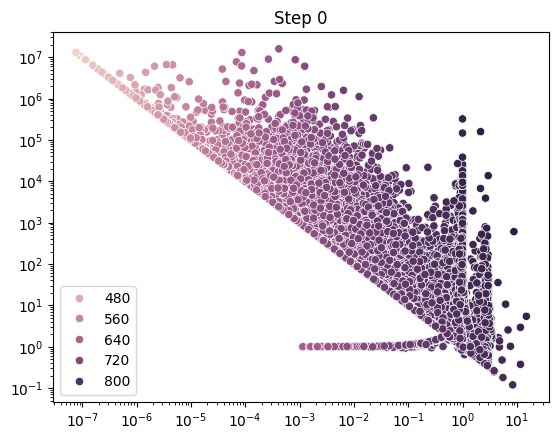

In [ ]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies

if run_mc:
    for step in range(total_steps):

        print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

        curr_eq = jax.vmap(
            partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
        _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

        ys0, ts0, ys1, ts1 = simulate(
            y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
        next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                    use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, 
                                                                    total_samples=total_samples, diversity=diversity)
        print(f'Choosing {len(next_idxs)} next circuits')
        if len(next_idxs) < choose_max:
            print('Not enough circuits chosen, will randomly choose the rest')
            idxs_rnd = choose_next_rnd(choose_max - len(next_idxs), total_samples)
            next_idxs = jnp.concatenate([next_idxs, idxs_rnd])
        
        if np.mod(step, int(total_steps/5)) == 0:
            plt.figure(figsize=(13, 5))
            ax = plt.subplot(1, 2, 1)
            sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
            plt.xscale('log')
            plt.yscale('log')
            ax = plt.subplot(1, 2, 2)
            sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
            plt.suptitle(f'Step {step}')


        # Save results
        all_params_en[step] = curr_en
        all_params_eq[step] = curr_eq
        all_params_rt[step] = curr_rt
        all_is_parent[step][next_idxs] = True
        all_adaptability[step] = adaptability
        all_sensitivity[step] = sensitivity
        all_precision[step] = precision

        # Mutate energies
        next_en = mutate_expand(
            curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
        print(f'Mutated and expanding {len(next_idxs)} into {len(next_en)} next circuits')
        curr_en = next_en

Text(0.5, 0.98, 'Step 1')

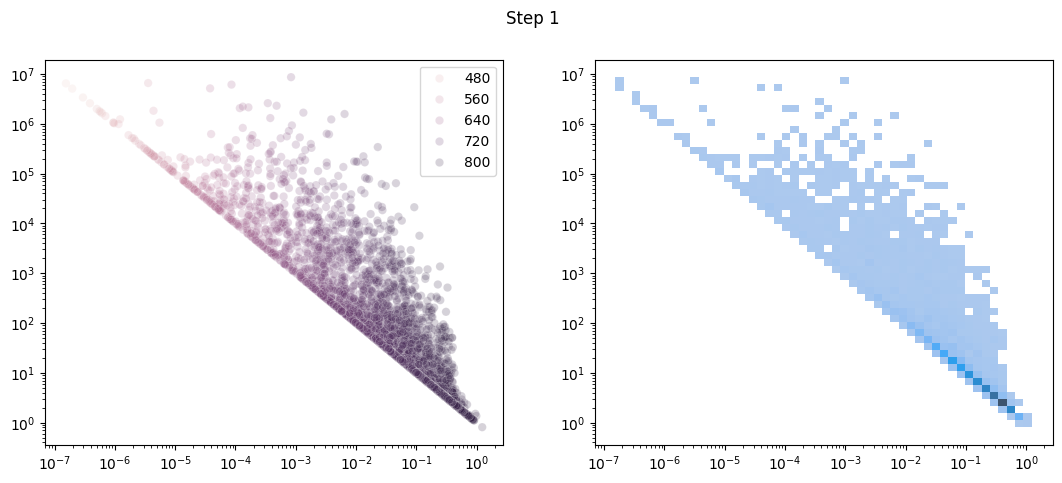

In [ ]:
if run_mc:
    plt.figure(figsize=(13, 5))
    ax = plt.subplot(1, 2, 1)
    sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    ax = plt.subplot(1, 2, 2)
    sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
    plt.suptitle(f'Step {step}')


# Visualise

In [ ]:
fn_save = f'results/23_Monte_Carlo_adaptability_2/23_Monte_Carlo_adaptability_n{total_samples}.csv'
if os.path.exists(fn_save):
    d = pd.read_csv(fn_save)
else:
    d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                        'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                        'Precision': all_precision[..., idxs_output].flatten(), 
                        'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                        'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                        'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                        'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                        'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                        'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                        'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})

In [ ]:
if not os.path.exists(fn_save):
    d.sort_values(by='Adaptability', ascending=False).to_csv(fn_save, index=False)


Maxima - Adaptability: 867.7872314453125, Sensitivity: 14.966212272644043, Precision: inf
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0


/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.p

Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0


/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.p

Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0
Maxima - Adaptability: 0.0, Sensitivity: 0.0, Precision: 0.0


/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')
/tmp/ipykernel_220909/1337795761.py:11: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')
/tmp/ipykernel_220909/1337795761.p

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

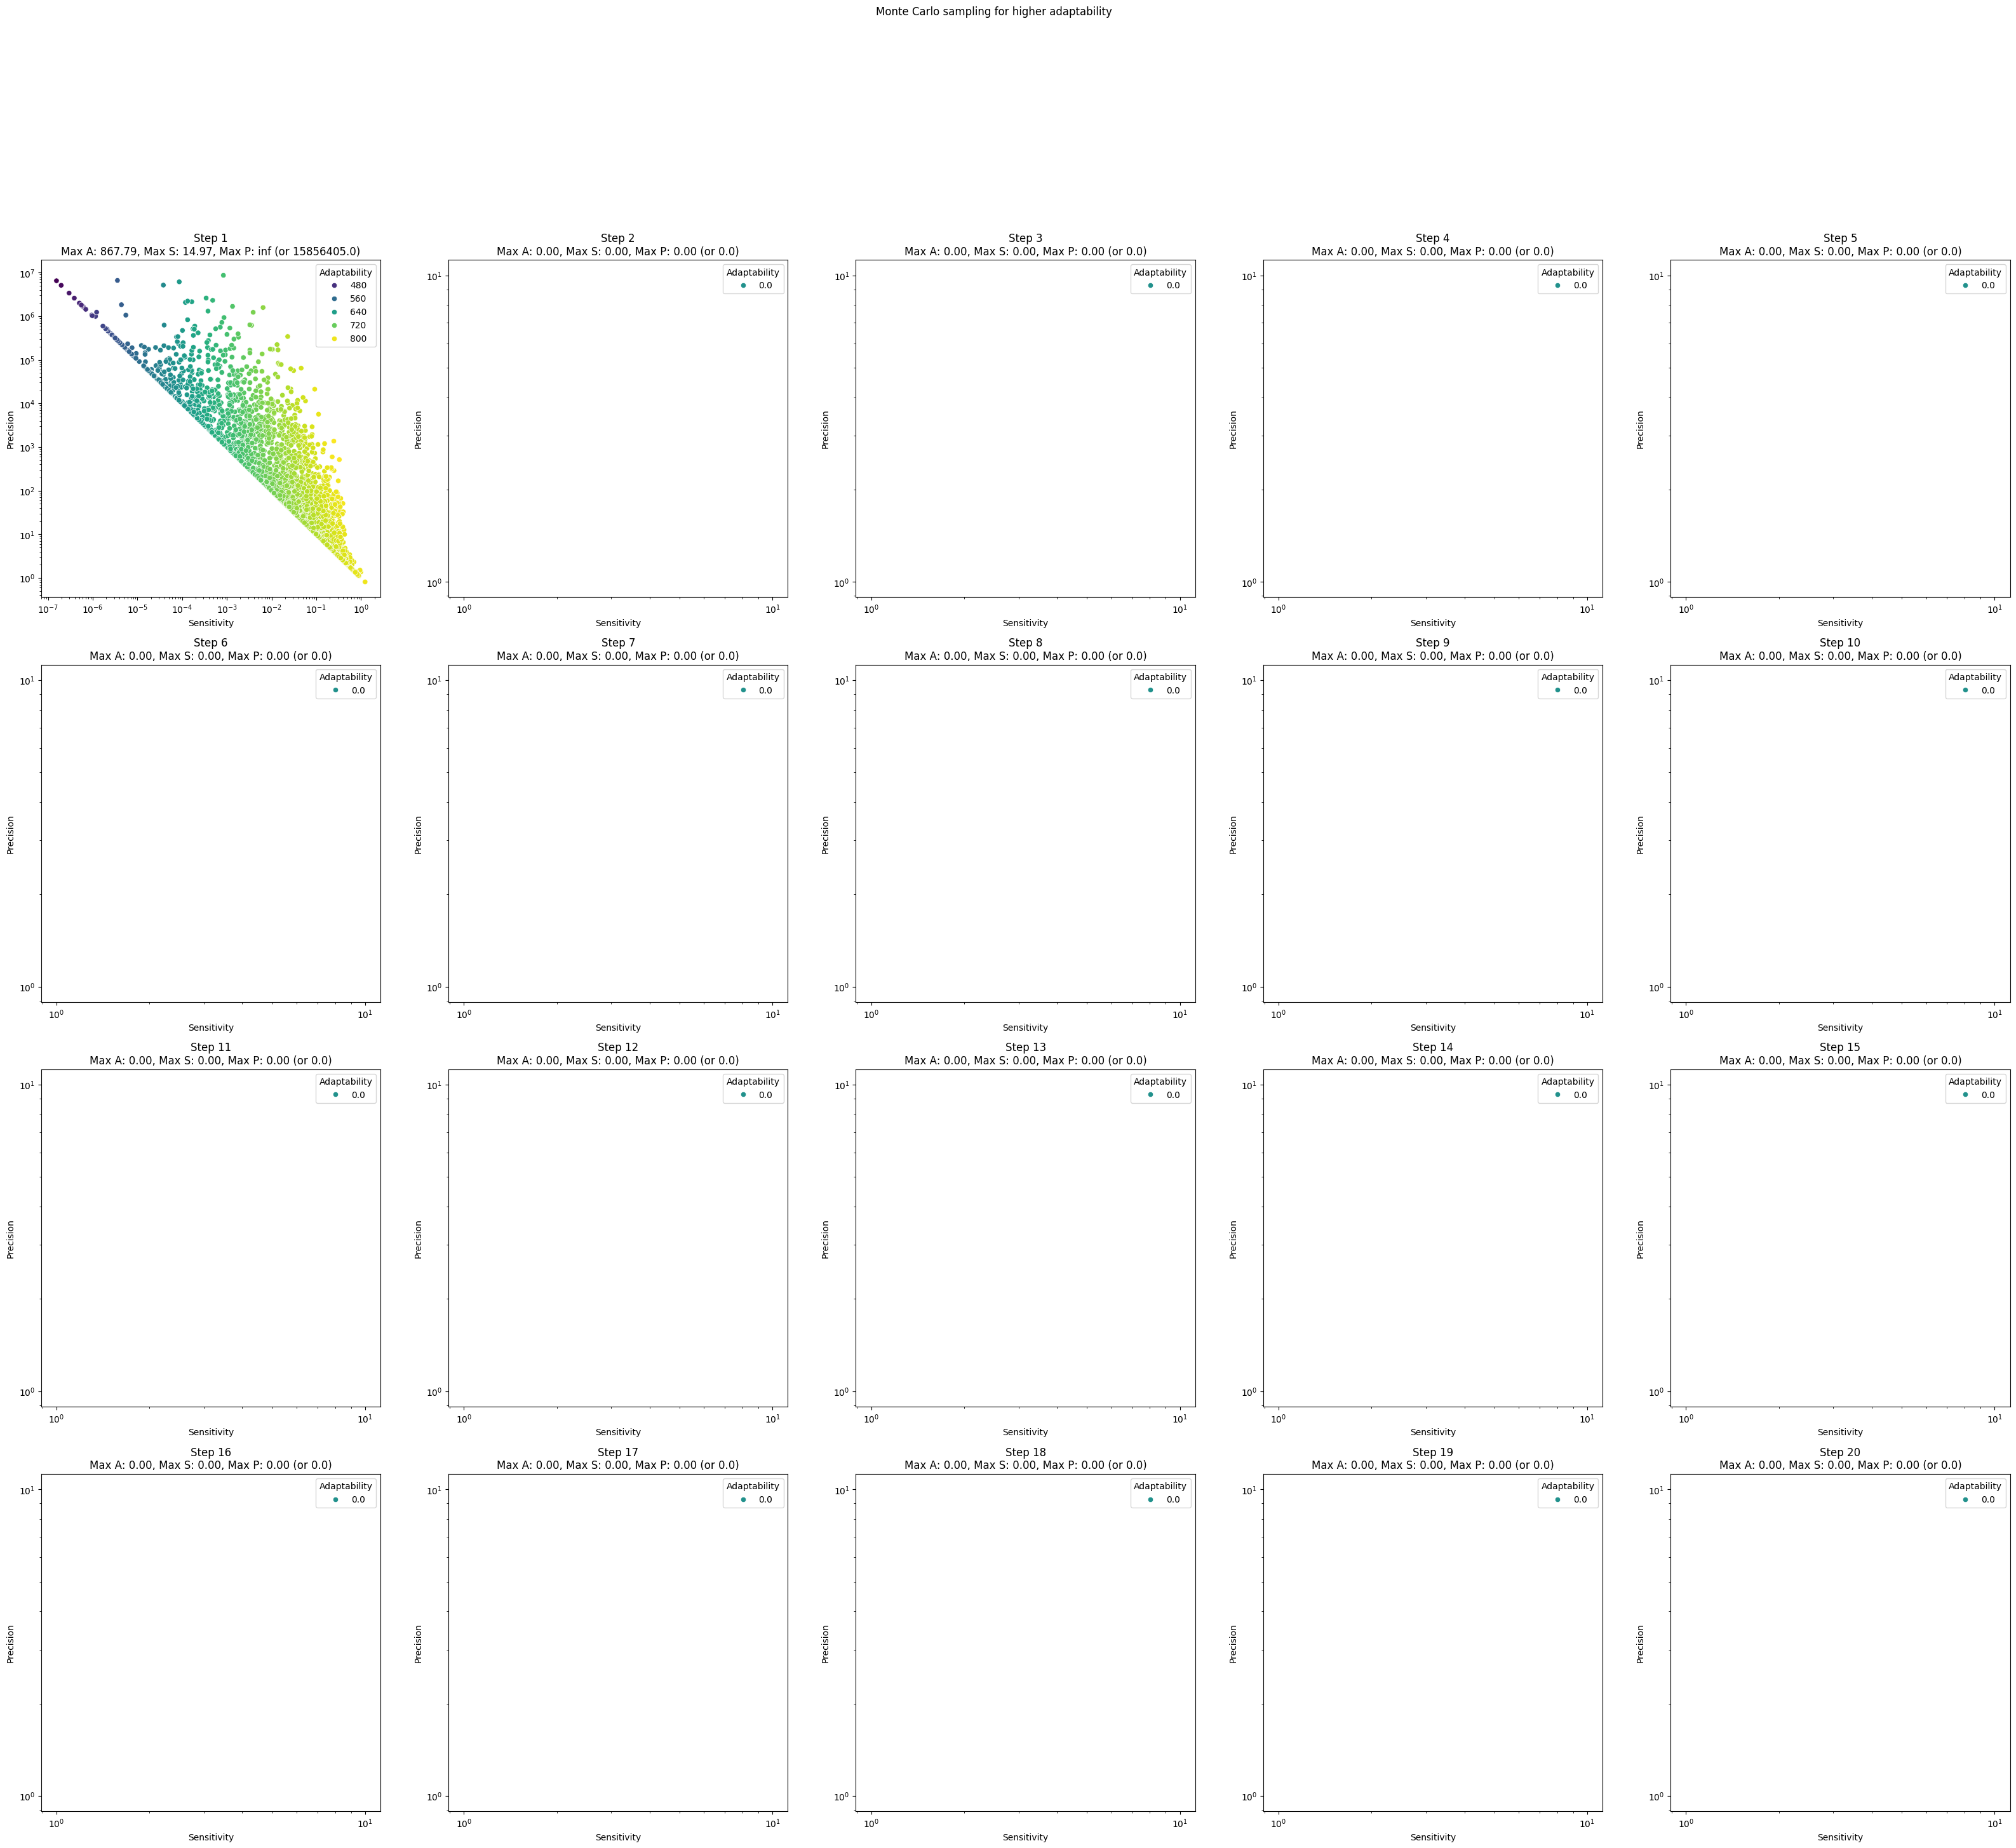

In [24]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {jnp.nanmax(a)}, Sensitivity: {jnp.nanmax(s)}, Precision: {jnp.nanmax(p)}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability', palette='viridis')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {jnp.nanmax(a):.2f}, Max S: {jnp.nanmax(s):.2f}, Max P: {jnp.nanmax(p):.2f} (or {jnp.nanmax(p[p < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: 811.5307006835938, Sensitivity: 3.989623546600342, Precision: 1177.682373046875
Maxima - Adaptability: 811.5289916992188, Sensitivity: 3.9889259338378906, Precision: 921.325927734375
Maxima - Adaptability: 811.5289916992188, Sensitivity: 3.988926649093628, Precision: 920.6748046875
Maxima - Adaptability: 811.5288696289062, Sensitivity: 3.9888713359832764, Precision: 858.291259765625
Maxima - Adaptability: 811.52880859375, Sensitivity: 3.9888558387756348, Precision: 850.313232421875
Maxima - Adaptability: 811.5274658203125, Sensitivity: 3.9882798194885254, Precision: 768.5489501953125
Maxima - Adaptability: 811.5274658203125, Sensitivity: 3.9882874488830566, Precision: 760.8218383789062
Maxima - Adaptability: 811.5274658203125, Sensitivity: 3.9882853031158447, Precision: 769.001220703125
Maxima - Adaptability: 811.5274658203125, Sensitivity: 3.9882895946502686, Precision: 751.255126953125
Maxima - Adaptability: 811.52734375, Sensitivity: 3.988229990005493, Precisi

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

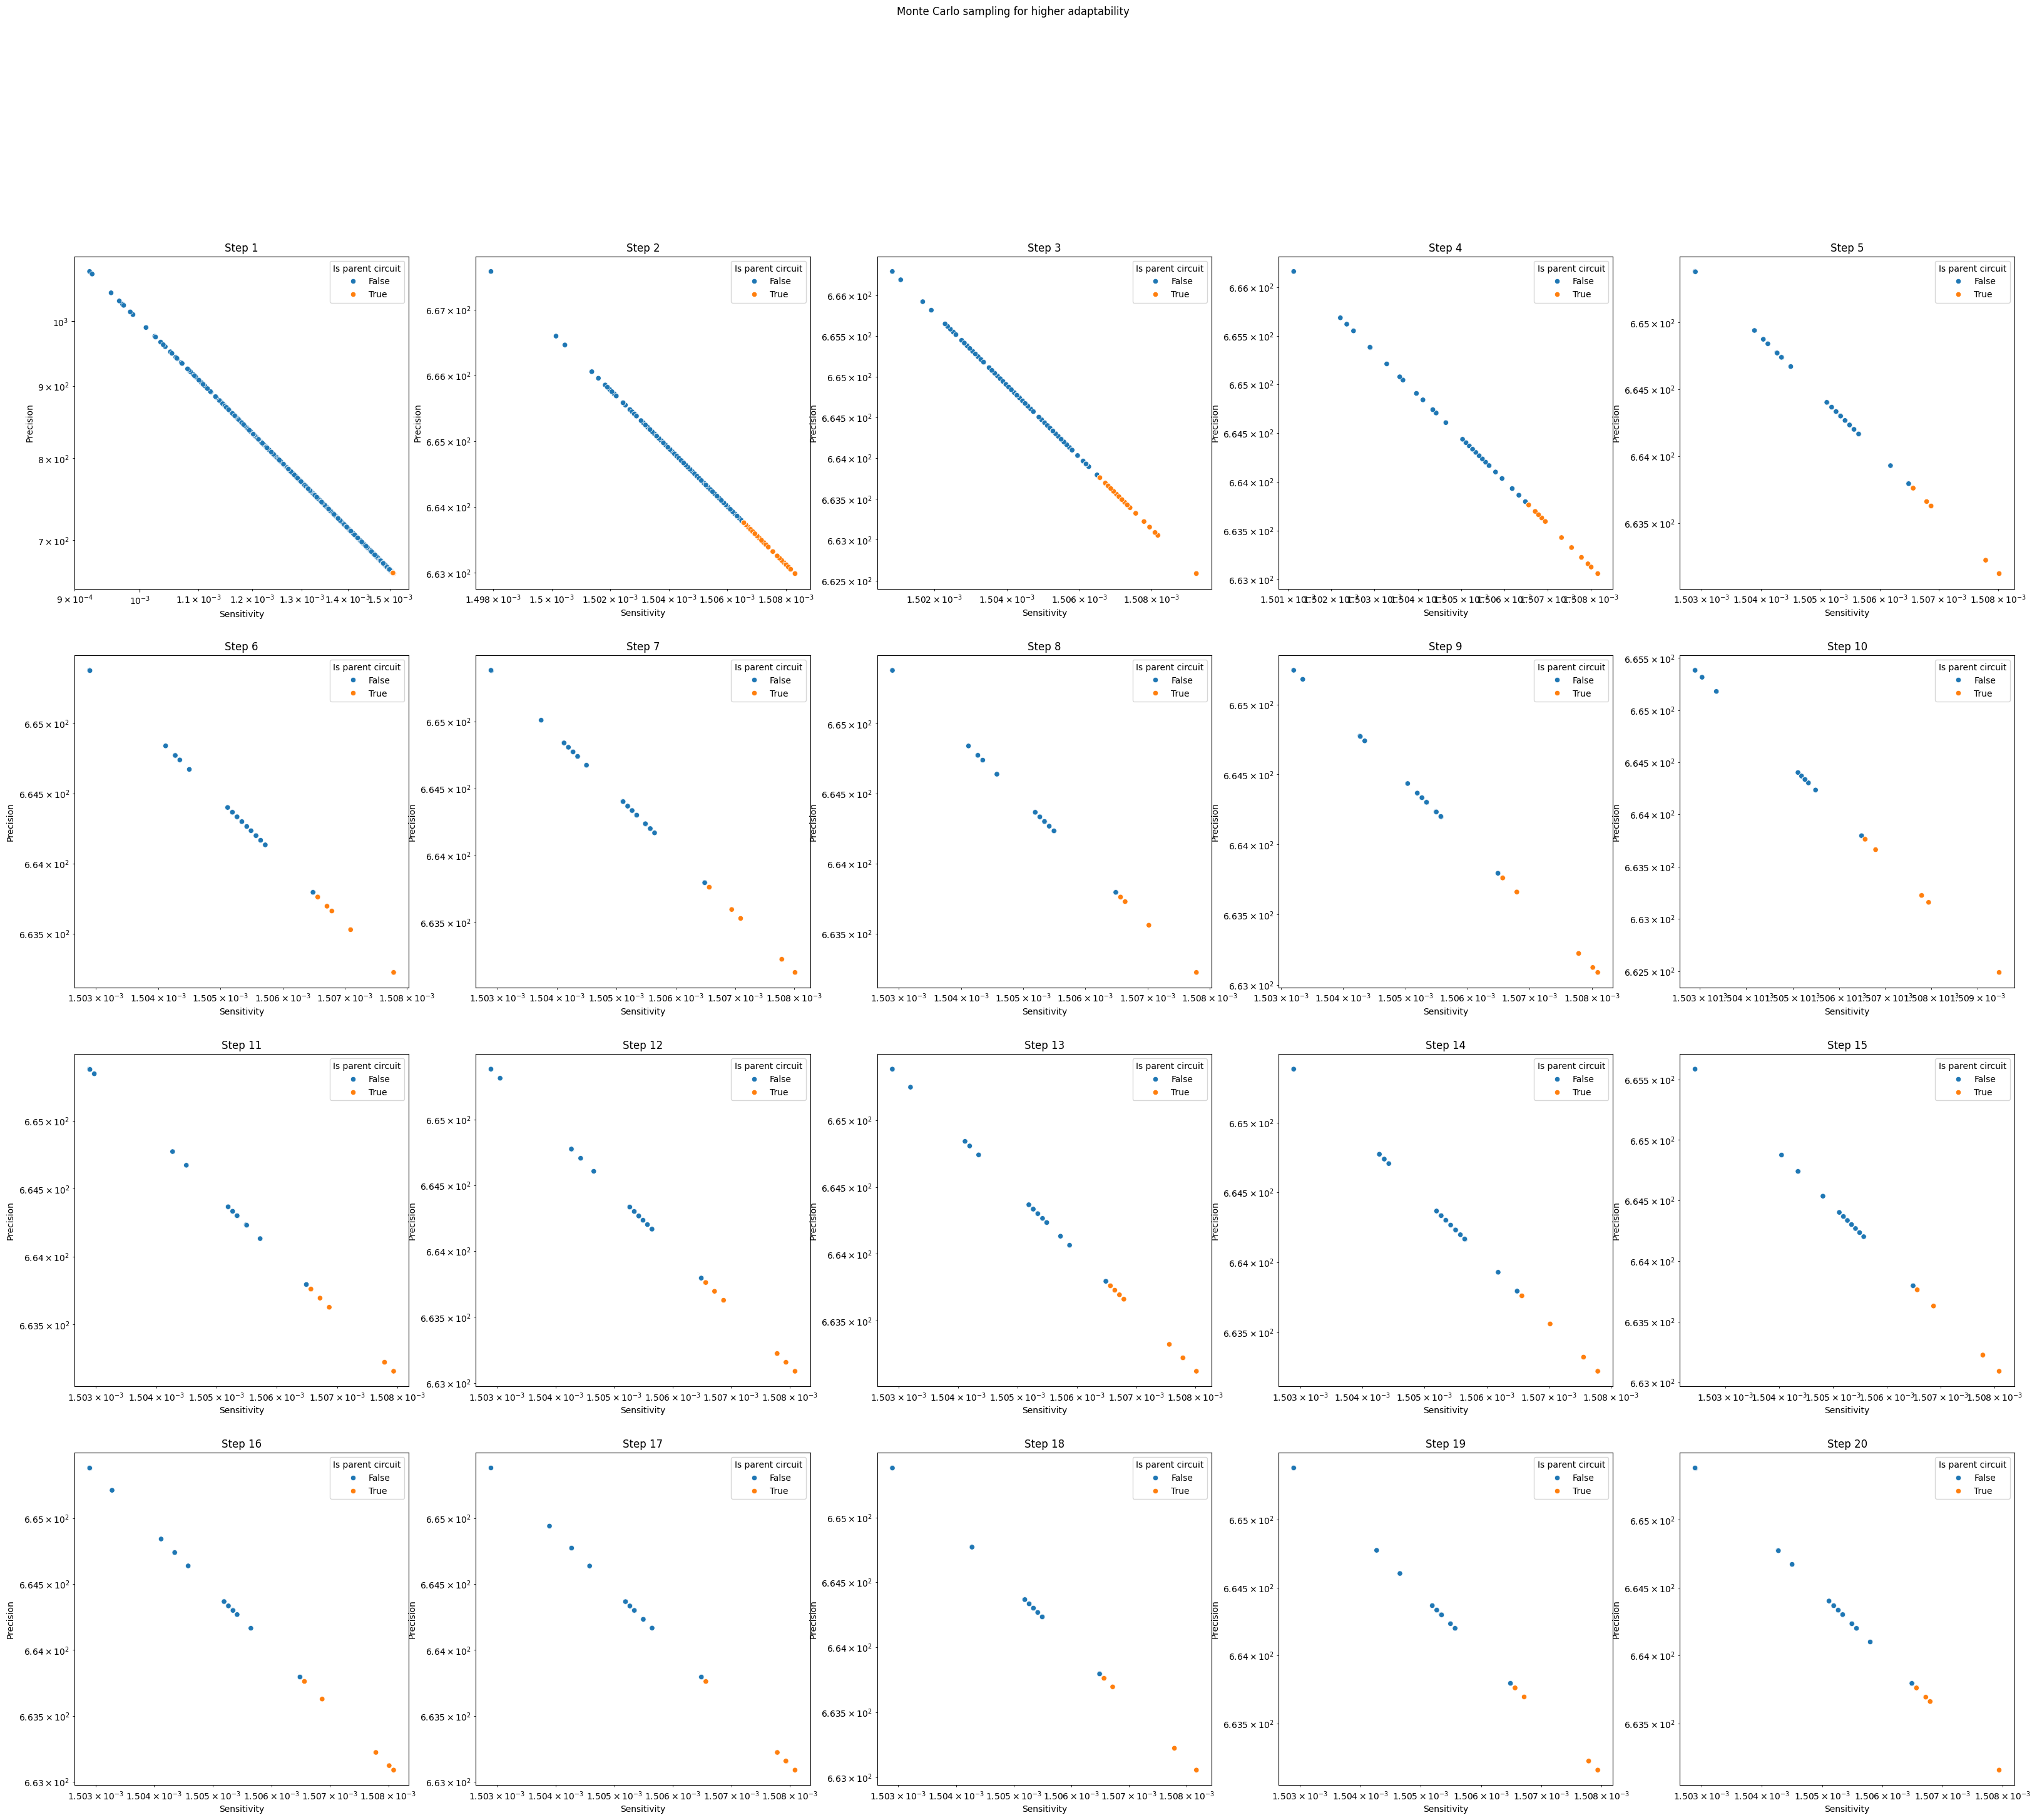

In [ ]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')

## Visualise histograms

Text(0.5, 1.0, 'Precision')

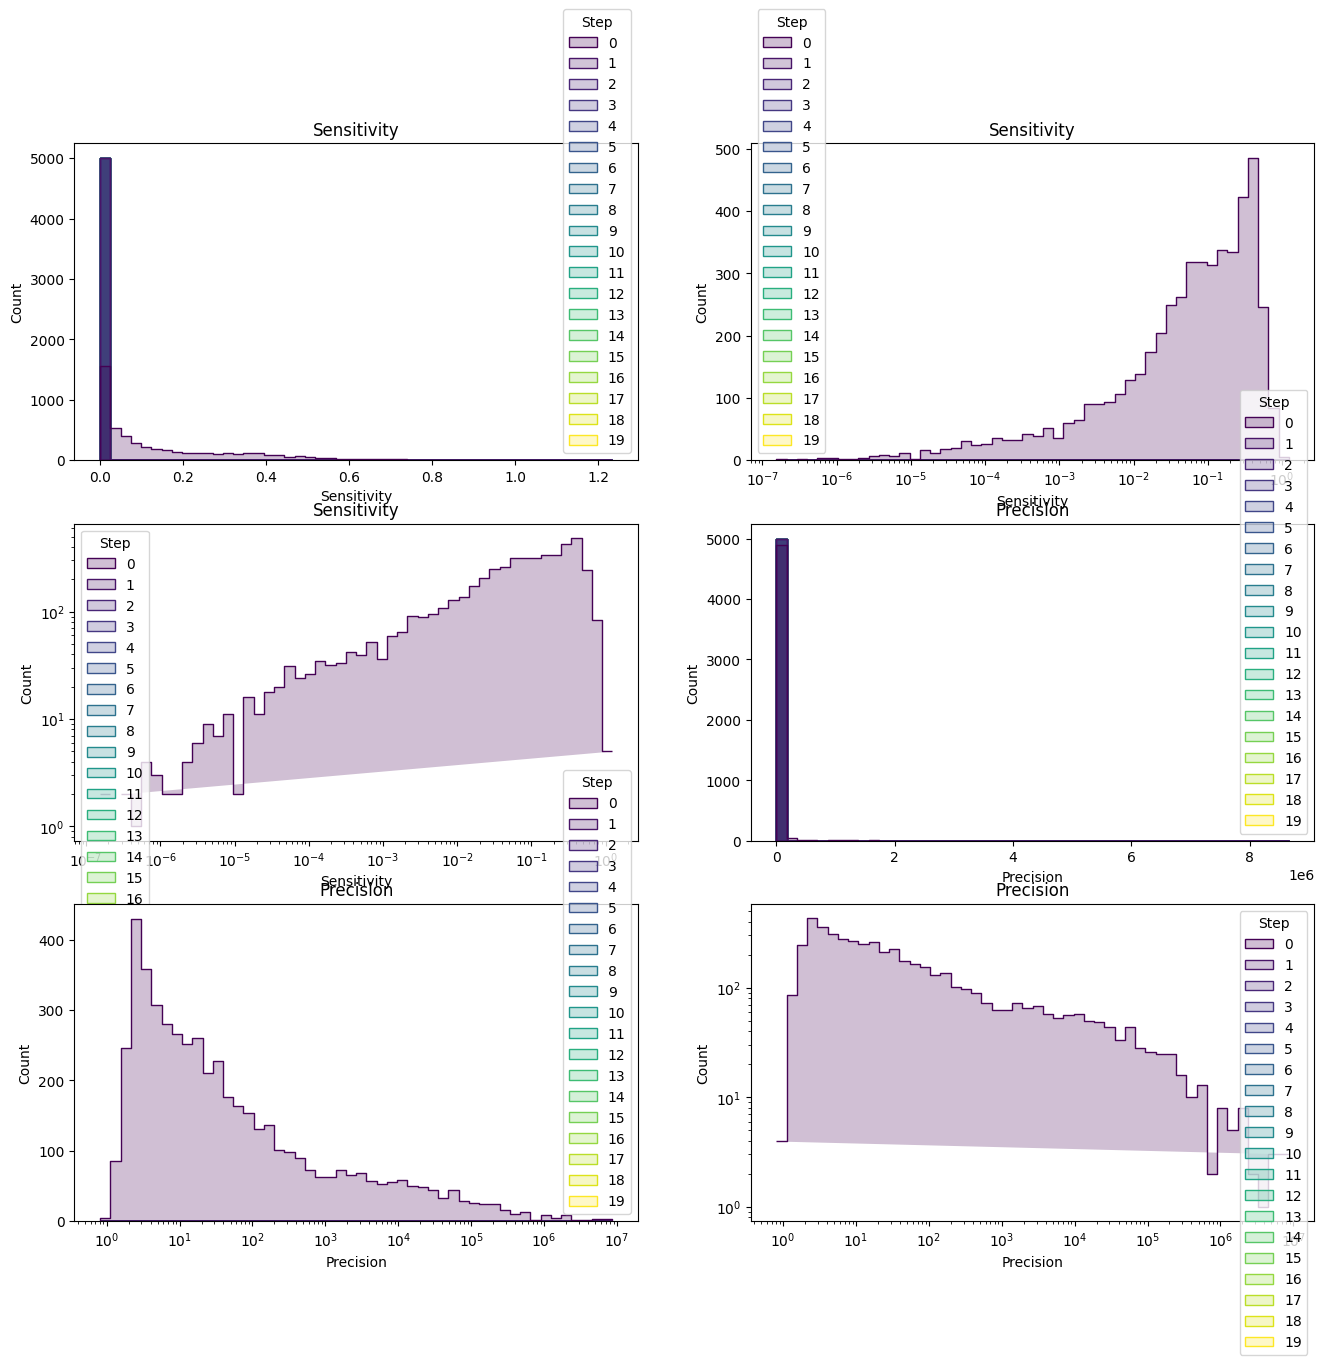

In [25]:
fig = plt.figure(figsize=(8*2, 7*2))
ax = plt.subplot(3, 2, 1)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 2)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 3)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 4)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 5)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(3, 2, 6)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis')
plt.title('Precision')


In [ ]:
d.sort_values(by='Adaptability', ascending=False).head(10)

,Adaptability,Sensitivity,Precision,Is parent circuit,Circuit idx,Species,Step,Params energy,Params equilibrium constants,Params rates
90,788.273987,0.500559,1.997765,True,9,RNA_2,9,"[-9.293237686157227, -4.805362224578857, -19.9...","[0.002840636298060417, 7.837326847948134e-05, ...","[0.5314235091209412, 19.26142692565918, 0.0001..."
91,787.841431,0.483922,2.066448,False,9,RNA_2,9,"[-11.661884307861328, -4.535679817199707, -19....","[0.018895907327532768, 6.316415965557098e-05, ...","[0.07988931238651276, 23.899328231811523, 0.00..."
80,787.826416,0.483355,2.068871,True,8,RNA_2,8,"[-11.975210189819336, -4.619874477386475, -19....","[0.024278858676552773, 6.756517541361973e-05, ...","[0.062176767736673355, 22.34259033203125, 0.00..."
94,787.815674,0.482951,2.070604,False,9,RNA_2,9,"[-11.163260459899902, -5.219462871551514, -14....","[0.012680258601903915, 0.0001091544036171399, ...","[0.11904969811439514, 13.829776763916016, 0.00..."
97,787.805054,0.482549,2.072330,False,9,RNA_2,9,"[-12.019525527954102, -4.974635601043701, -19....","[0.025155043229460716, 8.973863441497087e-05, ...","[0.06001106649637222, 16.82197380065918, 0.000..."
86,787.803345,0.482485,2.072605,False,8,RNA_2,8,"[-12.550859451293945, -4.117717266082764, -17....","[0.03847949206829071, 4.521220034803264e-05, 2...","[0.039230793714523315, 33.388797760009766, 0.0..."
87,787.794006,0.482135,2.074108,False,8,RNA_2,8,"[-13.001486778259277, -3.921966552734375, -18....","[0.055181488394737244, 3.865849066642113e-05, ...","[0.02735665626823902, 39.04914474487305, 0.000..."
98,787.790771,0.482012,2.074638,False,9,RNA_2,9,"[-11.818270683288574, -5.143342971801758, -15....","[0.02141420543193817, 0.00010270569327985868, ...","[0.07049437612295151, 14.698123931884766, 0.00..."
93,787.779114,0.481575,2.076519,False,9,RNA_2,9,"[-13.389936447143555, -4.327942848205566, -19....","[0.07529298961162567, 5.34928149136249e-05, 12...","[0.02004942297935486, 28.220256805419922, 0.00..."
96,787.772949,0.481344,2.077514,False,9,RNA_2,9,"[-12.400039672851562, -4.904868125915527, -19....","[0.034105878323316574, 8.486718434141949e-05, ...","[0.04426160827279091, 17.78757095336914, 0.000..."
